# Spam Detection of SMS 

Importing Required Libraries 

In [22]:
import pandas as pd 
import numpy as np
import re 
import string 
import nltk
import matplotlib.pyplot as plt 
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer 
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

a) Reading the dataset

In [2]:
df=pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## EDA

In [4]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Dropping Last 3 Columns - Unnamed:2 ,3,4. 

In [6]:
df.drop(['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], axis=1,inplace=True)

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data Preprocessing 

Steps in Preprocessing of Textual data include multiple steps :

    1) Converting all of the text to a single case - lowercase 
    2) Removal of stop words.
    3) Stemming & Lemmatization
    4) Tokenization
    5) Vectorization - as machine can't understand words but vectors only

In [8]:
stop_words = set(stopwords.words('english'))
stemmer = LancasterStemmer()

def cleaning_data(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'.pic\S+', '', text)
    text = re.sub(r'[^a-zA-Z+]', ' ', text)
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    ##text = " ".join([i for i in words if i not in stop_words and len(i) > 2])
    text = " ".join([stemmer.stem(i) for i in words if i not in stop_words and len(i) > 2])
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["CleanMessage"] = df["v2"].apply(cleaning_data)

In [9]:
df.head()

,v1,v2,CleanMessage
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy avail bug gre world buffet ...
1,ham,Ok lar... Joking wif u oni...,lar jok wif on
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,fre entry wkly comp win cup fin tkts may text ...
3,ham,U dun say so early hor... U c already then say...,dun say ear hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf liv around though


Now to check if the dataset is balanced or not

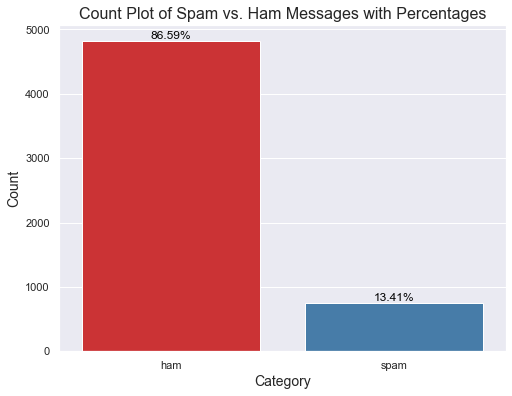

In [10]:
# Create a count plot
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='v1',data=df, palette="Set1")

# Calculate and display percentages on the bars
total = len(df['v1'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, color='black')

# Customize labels and title
ax.set_xlabel("Category", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
plt.title("Count Plot of Spam vs. Ham Messages with Percentages", fontsize=16)

plt.show()

We can see from the above graph that the dataset is highly imbalnaced and an imbalanced dataset can lead to :
    
    1) Bias Towards Majority Class: When a dataset is imbalanced, it often contains a majority class (e.g., "ham" in your spam vs. ham example) with a significantly larger number of samples than the minority class (e.g., "spam"). Machine learning models tend to be biased towards the majority class because they have more data to learn from. As a result, they may perform well on the majority class but poorly on the minority class.

    2) Reduced Model Performance: Imbalanced datasets can lead to models that have high accuracy but poor predictive performance, particularly for the minority class. This is because the model may simply predict the majority class for most examples, which is not desirable when you want to detect rare events or anomalies (e.g., fraud detection, disease diagnosis).

    3) Misleading Evaluation Metrics: Common evaluation metrics like accuracy can be misleading in imbalanced datasets. A model that predicts the majority class most of the time can have a high accuracy, but it may perform poorly in terms of precision, recall, and F1-score, which are more informative metrics for imbalanced datasets.

    4) Difficulty in Learning the Minority Class: Learning patterns in the minority class can be challenging due to the limited number of examples. Models may have difficulty distinguishing between different minority class instances, leading to incorrect predictions.

    5) Loss of Important Information: In some cases, the minority class represents critical or rare events that need to be detected. An imbalanced dataset may not provide enough information for the model to learn these events effectively, which can have serious consequences (e.g., missing fraudulent transactions in finance).

    6) Sensitivity to Sampling: Imbalanced datasets can be sensitive to the way data is sampled. Depending on how you split your data or resample it, you might get different results and model performance, making the analysis less stable.



Applying SMOTE here to fix the Dataset Imbalance Problem 

     SMOTE (Synthetic Minority Over-sampling Technique): SMOTE is a resampling technique that creates synthetic examples for the minority class in imbalanced datasets. It does this by interpolating between existing minority class samples, effectively increasing their representation. SMOTE helps machine learning models better learn from the minority class, reducing bias and improving classification accuracy.





In [11]:
# Encode labels ('spam' as 1, 'ham' as 0)
df['v1_encoded'] = df['v1'].map({'ham': 0, 'spam': 1})

In [13]:
# Split the data into training and testing sets
X = df['CleanMessage']  # Features
y = df['v1_encoded']    # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Apply TF-IDF vectorization to the text data
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [15]:
# Apply SMOTE to balance the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)


In [17]:
# Count the number of samples in each class
class_counts = y_train_resampled.value_counts()


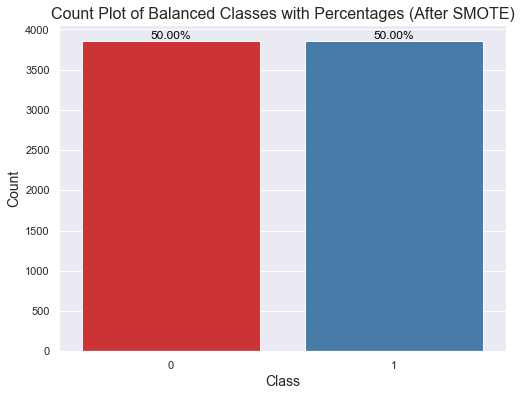

In [18]:
# Create a count plot with percentages
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=y_train_resampled, palette="Set1")

# Calculate and display percentages on the bars
total = len(y_train_resampled)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, color='black')

# Customize labels and title
ax.set_xlabel("Class", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
plt.title("Count Plot of Balanced Classes with Percentages (After SMOTE)", fontsize=16)

plt.show()

As we can see that we have a Balanced dataset now with Synthetic values , now we can proceed to the modelling phase 

## Modelling 

In [19]:
# Create and train the Naive Bayes classifier (Multinomial Naive Bayes)
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_resampled, y_train_resampled)


MultinomialNB()

In [20]:
# Predict on the testing data
y_pred = nb_classifier.predict(X_test_tfidf)

In [23]:
 #Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [24]:
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       965
           1       0.74      0.92      0.82       150

    accuracy                           0.95      1115
   macro avg       0.86      0.93      0.89      1115
weighted avg       0.95      0.95      0.95      1115

